In [71]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import torch
import random
import os
from torch.utils.data import Dataset, DataLoader, Subset
from torch import nn
# import albumentations as A
# from albumentations.pytorch import ToTensorV2
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
from ignite.metrics import Recall, Precision, Accuracy
from sklearn import metrics
import codecs
from efficientnet_pytorch import model as enet

In [72]:
torch.cuda.empty_cache()

### Config

In [73]:
conf_dict = {
    "batch_size": 8,
    "learn_rate": 1e-3,
    "min_learn_rate": 1e-6,
    "weight_decay": 1e-4,
    "epochs": 10,

    "transfer_model_name": "efficientnet-b1",
    "use_backbone": True,

    "train_dir": "../data/train/",
    "train_csv": "train_labels.csv",
    "test_dir": "../data/test/",
    "test_csv": "sample_submission.csv",
    "height": 512,
    "width": 512,

    "model": "schnaufnet_trained.pth",

    "origin_height": 273,
    "origin_width": 256,

    "only_use": 1000,
    "behaviours": {
        "all": "all",
        "only_1": "only_1",
        "50_50": "50_50",
        "weighted": "weighted",
    },
    "use_all": True,
}
current_split_behaviour = conf_dict["behaviours"]["50_50"]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [74]:
def set_seed(seed = 0):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    return random_state

random_state = set_seed(2021)

### Custom Dataset

In [75]:
class SETIDataset(Dataset):
	"""Dataset for training data"""
	def __init__(self, img_dir, test=False, transform=None, target_transform=None, use_cv_preprocessing=False):
		self.test = test
		if not self.test:
			self.img_labels = pd.read_csv(img_dir + conf_dict["train_csv"])
		else:
			self.img_labels = pd.read_csv(img_dir + conf_dict["test_csv"])
		self.img_labels['file_path'] = self.img_labels['id'].apply(self.get_file_path, dir=img_dir)
		self.img_dir = img_dir
		self.file_names = self.img_labels['file_path'].values
		self.transform = transform
		self.target_transform = target_transform
		self.use_cv_preprocessing = use_cv_preprocessing

	def __len__(self):
		return len(self.img_labels)

		# testing with single batch - for example with 1k epochs
		# return conf_dict["batch_size"]

	def __getitem__(self, idx):
		file_path = self.file_names[idx]
		image = np.load(file_path)
		image = image.astype(np.float32)

		# if self.use_cv_preprocessing:
		# 	cadence = Cadence(file_path)
		# 	cadence.cv()

		# image = np.vstack(image).T

		# if self.transform:
		# 	image = self.transform(image=image)['image']
		# else:
		# 	image = image[np.newaxis,:,:] # add dimension
		# 	image = torch.from_numpy(image).float()

		label = torch.tensor(self.img_labels["target"][idx]).float()

		# image = image.repeat(3, 1, 1) # TODO: probably just repeating the single channel isnt the best way => probably converting grayscale to rgb is better

		return image, label

	def get_file_path(self, image_id, dir):
		return dir + "{}/{}.npy".format(image_id[0], image_id)


In [76]:
class EfficientNetBackbone(nn.Module):
    def __init__(self, out_dim, backbone=None):
        super(EfficientNetBackbone, self).__init__()
        print("Initializing Efficientnet Backbone")
        model_name = conf_dict["transfer_model_name"]
        pretrained_model = {
            model_name: '../efficientnet-pytorch/efficientnet-b1-dbc7070a.pth'
        }
        self.enet = enet.EfficientNet.from_name(model_name)
        self.enet.load_state_dict(torch.load(pretrained_model[model_name]))
        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()
        self.conv1 = nn.Conv2d(6, 3, kernel_size=3, stride=1, padding=3, bias=False)

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.conv1(x)
        x = self.extract(x)
        x = self.myfc(x)
        return x

In [77]:
def split(dataset_whole_train, val_split, behaviour="all", use_all=True):
    dataset_whole_size = len(dataset_whole_train)
    if use_all:
        val_range = int(np.floor(val_split * dataset_whole_size))
        train_range = dataset_whole_size - val_range
        train_set, val_set = torch.utils.data.random_split(dataset_whole_train, [train_range, val_range])
    else:
        val_range = int(np.floor(val_split * conf_dict["only_use"]))
        train_range = conf_dict["only_use"] - val_range
        small_dataset_train = Subset(dataset_whole_train, np.random.randint(dataset_whole_size, size=conf_dict["only_use"]))
        train_set, val_set = torch.utils.data.random_split(small_dataset_train, [train_range, val_range])

    if behaviour == conf_dict["behaviours"]["only_1"]:
        print("Using only 1 labeled data...")
        train_indices_1_labels = [train_set.indices[i] for i in range(len(train_set)) if dataset_whole_train.img_labels["target"][train_set.indices[i]] == 1]
        train_sampler = SubsetRandomSampler(train_indices_1_labels)
        train_dataloader = DataLoader(dataset_whole_train, batch_size=conf_dict["batch_size"], sampler=train_sampler)
    if behaviour == conf_dict["behaviours"]["50_50"]:
        print("Using 50/50 data...")
        train_indices_1_labels = np.array([train_set.indices[i] for i in range(len(train_set)) if dataset_whole_train.img_labels["target"][train_set.indices[i]] == 1])
        train_indices_0_labels = np.array([train_set.indices[i] for i in range(len(train_set)) if dataset_whole_train.img_labels["target"][train_set.indices[i]] == 0])
        train_indices_0_labels_for_50_50 = list(np.random.choice(train_indices_0_labels, len(train_indices_1_labels), replace=False))
        indices_50_50 = list(train_indices_1_labels) + train_indices_0_labels_for_50_50
        train_sampler = SubsetRandomSampler(indices_50_50)
        train_dataloader = DataLoader(dataset_whole_train, batch_size=conf_dict["batch_size"], sampler=train_sampler)
    elif behaviour == conf_dict["behaviours"]["weighted"]: # not working properly => TODO: Fix this
        print("Using 50/50 weighted data...")
        labels = np.array([dataset_whole_train.img_labels["target"][train_set.indices[i]] for i in range(len(train_set))])
        class_counts = np.array(
            [len(np.where(labels == t)[0]) for t in np.unique(labels)])
        num_samples = sum(class_counts)
        class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
        weights = [class_weights[labels[i]] for i in range(int(num_samples))]
        sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))
        train_dataloader = DataLoader(
            dataset_whole_train, batch_size=conf_dict["batch_size"], sampler=sampler)
    elif behaviour == conf_dict["behaviours"]["all"]:
        print("Using original full data...")
        train_dataloader = DataLoader(train_set, batch_size=conf_dict["batch_size"], shuffle=True)#, num_workers=2)
    val_dataloader = DataLoader(val_set, batch_size=conf_dict["batch_size"], shuffle=True)#, num_workers=2)

    # get_0_1_batches_ratio(train_dataloader)
    # get_0_1_ratio(train_dataloader, train=True)

    # image, label = next(iter(train_dataloader))
    # print("Shape of image [N, C, H, W]: ", image.shape)
    # print("Shape of label: ", label.shape, label.dtype)

    print(f"Successfully splitted dataset!\n Trainbatches: {len(train_dataloader)}\n Validationbatches: {len(val_dataloader)}")

    return train_dataloader, val_dataloader

def get_0_1_batches_ratio(dataloader):
    for i, (data, target) in enumerate(dataloader):
        print (f"batch index {i}, 0/1: {len(np.where(target.numpy() == 0)[0])}/{len(np.where(target.numpy() == 1)[0])}")

def get_0_1_ratio(dataloader, train):
    print("dataloader length: ", len(dataloader))
    dataloader_0 = 0
    dataloader_1 = 0
    for i, (data, target) in enumerate(dataloader):
        dataloader_0 += len(np.where(target.numpy() == 0)[0])
        dataloader_1 += len(np.where(target.numpy() == 1)[0])
        if i % 100 == 99:
            print(f"calced {i}/{len(dataloader)}")
    dataloaderinformation = "train" if train else "val"
    print(f"{dataloaderinformation} dataloader 0/1 ratio: {dataloader_0}, {dataloader_1}")

In [78]:
def train_loop(model, train_dataloader, optimizer, loss_fn, scheduler):
    print("Starting model training...")
    model.train()
    epoch_loss = 0
    epoch_loss_list = []
    num_batches = len(train_dataloader)

    accuracy = Accuracy()
    precision = Precision()
    recall = Recall()

    for (images, labels) in tqdm(train_dataloader, position=0, leave=True, desc='Training'):
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)

        optimizer.zero_grad()
        pred = model(images)
        loss = loss_fn(pred.view(labels.size(0)), labels.to(torch.float32))
        epoch_loss_list.append(loss.item())
        epoch_loss += loss.item() # add loss for whole batch
        loss.backward()
        optimizer.step()
        scheduler.step()
        predicted = torch.sigmoid(pred).round() # if precision gets higher => write own function which does not seperate <0.5 and >=0.5 like round currently does
        accuracy.update((predicted, labels))
        precision.update((predicted, labels))
        recall.update((predicted, labels))

    avg_epoch_loss = epoch_loss / num_batches
    print(f"""Training Error: \n 
        Accuracy: {100*accuracy.compute():>2f}%, \n
        Recall: {100*recall.compute():>2f}%, \n
        Precision: {100*precision.compute():>2f}%, \n
        Avg loss: {avg_epoch_loss:>2f} \n
    """) # avg loss is summed losses for all batches divided with num batches
    # print(f"Epoch loss list: {epoch_loss_list}")
    with codecs.open('schnaufNet2.0 train.log', 'a') as up:
        up.write(f"""Validation Error: \n
            Accuracy: {100*accuracy.compute():2f}%, \n
            Recall: {100*recall.compute():2f}%, \n
            Precision: {100*precision.compute():>2f}%, \n
            Avg loss: {avg_epoch_loss:>2f} \n
        """)
    plt.plot(epoch_loss_list, "ro-")
    plt.title("Loss over epoch")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()

def validation_loop(model, val_dataloader, loss_fn):
    print("Starting model validation...")
    model.eval()

    epoch_loss = 0
    num_batches = len(val_dataloader)
    epoch_labels = []
    epoch_preds = []

    accuracy = Accuracy()
    precision = Precision()
    recall = Recall()

    with torch.no_grad():
        for (images, labels) in tqdm(val_dataloader, position=0, leave=True, desc='Evaluating'):
            images = images.to(device)
            labels = labels.to(device)

            pred = model(images)
            loss = loss_fn(pred.view(labels.size(0)), labels.to(torch.float32))
            epoch_loss += loss.item()
            predicted = torch.sigmoid(pred).round()
            accuracy.update((predicted, labels))
            precision.update((predicted, labels))
            recall.update((predicted, labels))
            
            labels = labels.detach().cpu().numpy().tolist()
            predicted = predicted.detach().cpu().numpy().tolist()
            epoch_labels.extend(labels)
            epoch_preds.extend(predicted)

    avg_epoch_loss = epoch_loss / num_batches
    print(f"""Validation Error: \n
        Accuracy: {100*accuracy.compute():2f}%, \n
        Recall: {100*recall.compute():2f}%, \n
        Precision: {100*precision.compute():>2f}%, \n
        Avg loss: {avg_epoch_loss:>2f} \n
    """)
    with codecs.open('schnaufNet2.0 validation.log', 'a') as up:
        up.write(f"""Validation Error: \n
            Accuracy: {100*accuracy.compute():2f}%, \n
            Recall: {100*recall.compute():2f}%, \n
            Precision: {100*precision.compute():>2f}%, \n
            Avg loss: {avg_epoch_loss:>2f} \n
        """)
    return epoch_labels, epoch_preds

In [79]:
def get_transforms(data):
    pass
    # if data == 'train':
    #     return A.Compose([
    #         # A.Resize(conf_dict["height"], conf_dict["width"]),
    #         A.VerticalFlip(p=0.5),
    #         A.HorizontalFlip(p=0.5),
    #         ToTensorV2(),
    #     ])
    # elif data == 'val' or data == 'test':
    #     return A.Compose([
    #         # A.Resize(conf_dict["height"], conf_dict["width"]),
    #         ToTensorV2(),
    #     ])

Initializing Efficientnet Backbone
Using 50/50 data...
Successfully splitted dataset!
 Trainbatches: 1115
 Validationbatches: 1875
Epoch 1/10
-------------------------------
Starting model training...


Training: 100%|██████████| 1115/1115 [14:00<00:00,  1.33it/s]

Training Error: 
 
        Accuracy: 53.766816%, 

        Recall: 51.300448%, 

        Precision: 53.962264%, 

        Avg loss: 0.694193 

    


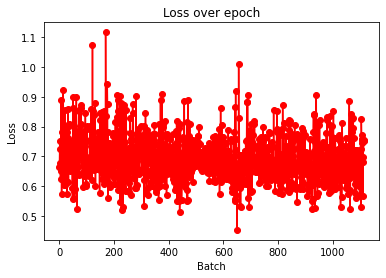

Starting model validation...


Evaluating: 100%|██████████| 1875/1875 [25:44<00:00,  1.21it/s]


Validation Error: 

        Accuracy: 83.333333%, 

        Recall: 32.857143%, 

        Precision: 25.659229%, 

        Avg loss: 0.565532 

    
Val ROC AUC Score: 0.6098280619825939
Epoch 2/10
-------------------------------
Starting model training...


Training: 100%|██████████| 1115/1115 [14:17<00:00,  1.30it/s]

Training Error: 
 
        Accuracy: 59.080717%, 

        Recall: 46.547085%, 

        Precision: 62.118492%, 

        Avg loss: 0.662157 

    


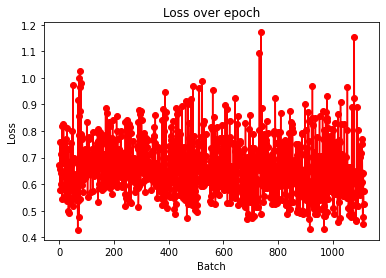

Starting model validation...


Evaluating: 100%|██████████| 1875/1875 [11:05<00:00,  2.82it/s]


Validation Error: 

        Accuracy: 89.300000%, 

        Recall: 28.181818%, 

        Precision: 46.516613%, 

        Avg loss: 0.501036 

    
Val ROC AUC Score: 0.6223726867486155
Epoch 3/10
-------------------------------
Starting model training...


Training: 100%|██████████| 1115/1115 [07:06<00:00,  2.61it/s]

Training Error: 
 
        Accuracy: 62.096413%, 

        Recall: 47.892377%, 

        Precision: 66.896336%, 

        Avg loss: 0.638324 

    


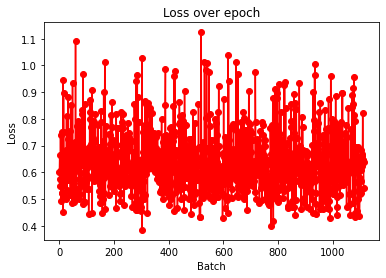

Starting model validation...


Evaluating: 100%|██████████| 1875/1875 [05:38<00:00,  5.54it/s]


Validation Error: 

        Accuracy: 90.846667%, 

        Recall: 25.909091%, 

        Precision: 63.232964%, 

        Avg loss: 0.513304 

    
Val ROC AUC Score: 0.6209273267594217
Epoch 4/10
-------------------------------
Starting model training...


Training: 100%|██████████| 1115/1115 [06:44<00:00,  2.76it/s]

Training Error: 
 
        Accuracy: 63.991031%, 

        Recall: 52.264574%, 

        Precision: 68.277680%, 

        Avg loss: 0.624569 

    


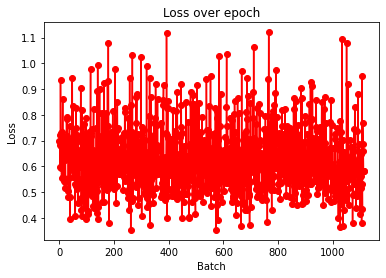

Starting model validation...


Evaluating: 100%|██████████| 1875/1875 [05:26<00:00,  5.74it/s]


Validation Error: 

        Accuracy: 72.026667%, 

        Recall: 57.402597%, 

        Precision: 19.981917%, 

        Avg loss: 0.683040 

    
Val ROC AUC Score: 0.6555122440709364
Epoch 5/10
-------------------------------
Starting model training...


Training: 100%|██████████| 1115/1115 [06:41<00:00,  2.77it/s]

Training Error: 
 
        Accuracy: 65.000000%, 

        Recall: 53.811659%, 

        Precision: 69.324090%, 

        Avg loss: 0.608312 

    


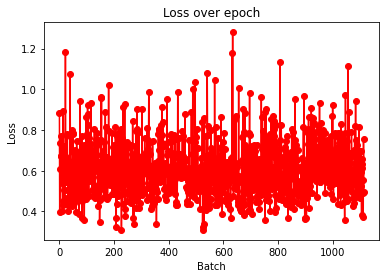

Starting model validation...


Evaluating: 100%|██████████| 1875/1875 [05:26<00:00,  5.75it/s]


Validation Error: 

        Accuracy: 89.973333%, 

        Recall: 35.389610%, 

        Precision: 51.707780%, 

        Avg loss: 0.431711 

    
Val ROC AUC Score: 0.6580401767623165
Epoch 6/10
-------------------------------
Starting model training...


Training: 100%|██████████| 1115/1115 [06:53<00:00,  2.69it/s]

Training Error: 
 
        Accuracy: 65.291480%, 

        Recall: 53.901345%, 

        Precision: 69.802555%, 

        Avg loss: 0.601054 

    


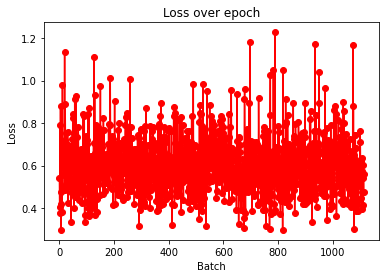

Starting model validation...


Evaluating: 100%|██████████| 1875/1875 [05:30<00:00,  5.67it/s]


Validation Error: 

        Accuracy: 86.226667%, 

        Recall: 43.896104%, 

        Precision: 35.995740%, 

        Avg loss: 0.468254 

    
Val ROC AUC Score: 0.674829702244264
Epoch 7/10
-------------------------------
Starting model training...


Training: 100%|██████████| 1115/1115 [06:54<00:00,  2.69it/s]

Training Error: 
 
        Accuracy: 67.062780%, 

        Recall: 56.300448%, 

        Precision: 71.742857%, 

        Avg loss: 0.584381 

    


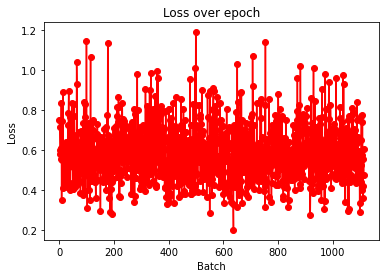

Starting model validation...


Evaluating: 100%|██████████| 1875/1875 [05:32<00:00,  5.64it/s]


Validation Error: 

        Accuracy: 91.626667%, 

        Recall: 32.857143%, 

        Precision: 69.505495%, 

        Avg loss: 0.373351 

    
Val ROC AUC Score: 0.6560390575249415
Epoch 8/10
-------------------------------
Starting model training...


Training: 100%|██████████| 1115/1115 [07:14<00:00,  2.56it/s]

Training Error: 
 
        Accuracy: 68.060538%, 

        Recall: 56.255605%, 

        Precision: 73.642501%, 

        Avg loss: 0.571896 

    


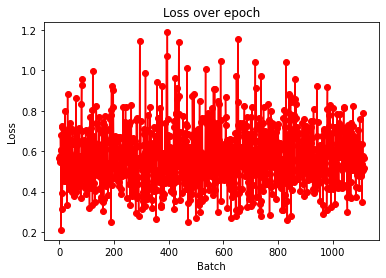

Starting model validation...


Evaluating: 100%|██████████| 1875/1875 [05:25<00:00,  5.76it/s]


Validation Error: 

        Accuracy: 90.013333%, 

        Recall: 32.207792%, 

        Precision: 52.210526%, 

        Avg loss: 0.472899 

    
Val ROC AUC Score: 0.6441741764921558
Epoch 9/10
-------------------------------
Starting model training...


Training: 100%|██████████| 1115/1115 [06:41<00:00,  2.77it/s]

Training Error: 
 
        Accuracy: 68.587444%, 

        Recall: 58.340807%, 

        Precision: 73.378455%, 

        Avg loss: 0.564681 

    


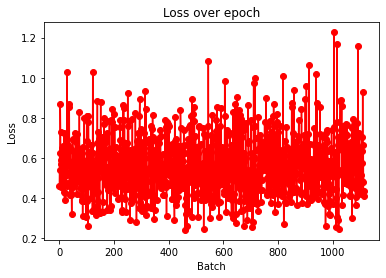

Starting model validation...


Evaluating: 100%|██████████| 1875/1875 [05:07<00:00,  6.09it/s]


Validation Error: 

        Accuracy: 89.993333%, 

        Recall: 35.714286%, 

        Precision: 51.837889%, 

        Avg loss: 0.439612 

    
Val ROC AUC Score: 0.659589259180641
Epoch 10/10
-------------------------------
Starting model training...


Training: 100%|██████████| 1115/1115 [06:39<00:00,  2.79it/s]

Training Error: 
 
        Accuracy: 69.573991%, 

        Recall: 58.408072%, 

        Precision: 75.202079%, 

        Avg loss: 0.552349 

    


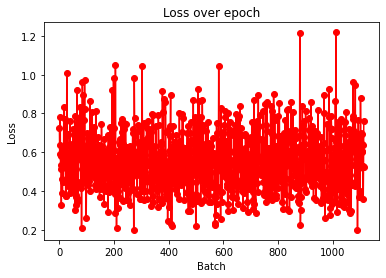

Starting model validation...


Evaluating: 100%|██████████| 1875/1875 [05:12<00:00,  6.00it/s]


Validation Error: 

        Accuracy: 89.173333%, 

        Recall: 39.415584%, 

        Precision: 46.764253%, 

        Avg loss: 0.412180 

    
Val ROC AUC Score: 0.671409274232454
Training done! Saving model...
Saved model!


In [80]:
model = EfficientNetBackbone(out_dim=1)
model.to(device)

dataset_whole_train = SETIDataset(conf_dict["train_dir"], transform=get_transforms(data="train"))#, use_cv_preprocessing_preprocessing=True)
dataset_whole_val = SETIDataset(conf_dict["train_dir"], transform=get_transforms(data="val"))#, use_cv_preprocessing=True) # extra dataset für validation, da validation data nicht transformiert werden darf

train_dataloader, val_dataloader = split(dataset_whole_train, val_split=0.25, behaviour=current_split_behaviour, use_all=conf_dict["use_all"])

loss_fn = nn.BCEWithLogitsLoss() # nn.BCELoss() => needs sigmoid as activation function
optimizer = torch.optim.Adam(model.parameters(), lr=conf_dict["learn_rate"], weight_decay=conf_dict["weight_decay"]) # torch.optim.SGD(model.parameters(), lr=conf_dict["learn_rate"]) 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=conf_dict["epochs"], eta_min=conf_dict["min_learn_rate"], last_epoch=-1
)

num_epochs = conf_dict["epochs"]
with codecs.open('schnaufNet2.0 train.log', 'a') as up:
    up.write("------------------ new training ------------------")
with codecs.open('schnaufNet2.0 validation.log', 'a') as up:
    up.write("------------------ new validation ------------------")
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}\n-------------------------------")
    if epoch == num_epochs / 4 * 3:
        pass # TODO: implement changed behaviour => train_dataloader and val_dataloader should change here

    train_loop(model, train_dataloader, optimizer, loss_fn, scheduler)
    val_labels, val_predictions = validation_loop(model, val_dataloader, loss_fn)
    roc_auc = metrics.roc_auc_score(val_labels, val_predictions)
    print(f"Val ROC AUC Score: {roc_auc}")
    with codecs.open('schnaufNet2.0 validation.log', 'a') as up:
        up.write(f"""
            Epoch={epoch}, Valid ROC AUC={roc_auc}\n
        """)
print("Training done! Saving model...")
torch.save(model.state_dict(), conf_dict["model"])
print("Saved model!")